## 1. module import 

In [1]:
import os
import sys
import argparse
import numpy as np
import time
import glob
import cv2

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath('/home/juju/contact_graspnet/contact_graspnet/inference.py')))
sys.path.append(os.path.join(BASE_DIR))
sys.path.append(os.path.join('/home/juju/contact_graspnet/contact_graspnet'))

import config_utils
from data import regularize_pc_point_count, depth2pc, load_available_input_data

from contact_graspnet import contact_graspnet

from contact_grasp_estimator import GraspEstimator
from visualization_utils import visualize_grasps, show_image

2023-05-21 23:14:57.052701: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-05-21 23:14:57.831193: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-05-21 23:14:57.902322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-21 23:14:57.902457: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3050 Ti Laptop GPU computeCapability: 8.6
coreClock: 1.485GHz coreCount: 20 deviceMemorySize: 3.81GiB deviceMemoryBandwidth: 178.84GiB/s
2023-05-21 23:14:57.902474: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-05-21 23:14:57.905108: I tensorflow/str

/home/juju/contact_graspnet/pointnet2/tf_ops/sampling


## 2. argument setting

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--ckpt_dir', default='checkpoints/scene_test_2048_bs3_hor_sigma_001', help='Log dir [default: checkpoints/scene_test_2048_bs3_hor_sigma_001]')
parser.add_argument('--np_path', default='test_data/7.npy', help='Input data: npz/npy file with keys either "depth" & camera matrix "K" or just point cloud "pc" in meters. Optionally, a 2D "segmap"')
parser.add_argument('--png_path', default='', help='Input data: depth map png in meters')
parser.add_argument('--K', default=None, help='Flat Camera Matrix, pass as "[fx, 0, cx, 0, fy, cy, 0, 0 ,1]"')
parser.add_argument('--z_range', default=[0.2,1.8], help='Z value threshold to crop the input point cloud')
parser.add_argument('--local_regions', action='store_true', default=False, help='Crop 3D local regions around given segments.')
parser.add_argument('--filter_grasps', action='store_true', default=False,  help='Filter grasp contacts according to segmap.')
parser.add_argument('--skip_border_objects', action='store_true', default=False,  help='When extracting local_regions, ignore segments at depth map boundary.')
parser.add_argument('--forward_passes', type=int, default=1,  help='Run multiple parallel forward passes to mesh_utils more potential contact points.')
parser.add_argument('--segmap_id', type=int, default=0,  help='Only return grasps of the given object id')
parser.add_argument('--arg_configs', nargs="*", type=str, default=[], help='overwrite config parameters')

FLAGS = parser.parse_args(args=[])

## 3. Config setting

In [3]:
FLAGS.arg_configs

[]

In [4]:
global_config = config_utils.load_config(FLAGS.ckpt_dir, batch_size=FLAGS.forward_passes, arg_configs=FLAGS.arg_configs)

# inference 시 사용할 batch_size이기 때문에 batch를 1로 셋팅한다. 
FLAGS.forward_passes

global_config

/home/juju/contact_graspnet/contact_graspnet/config_utils.py:42: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  global_config = yaml.load(f)


{'DATA': {'scene_contacts_path': 'acronym/scene_contacts',
  'gripper_width': 0.08,
  'input_normals': False,
  'use_uniform_quaternions': False,
  'view_sphere': {'elevation': [30, 150], 'distance_range': [0.9, 1.3]},
  'train_on_scenes': True,
  'labels': {'to_gpu': False,
   'bin_weights': [0.16652107,
    0.21488856,
    0.37031708,
    0.55618503,
    0.75124664,
    0.93943357,
    1.07824539,
    1.19423112,
    1.55731375,
    3.17161779],
   'filter_z': True,
   'k': 1,
   'max_radius': 0.005,
   'num_neg_contacts': 0,
   'num_pos_contacts': 8000,
   'offset_bins': [0,
    0.00794435329,
    0.0158887021,
    0.0238330509,
    0.0317773996,
    0.0397217484,
    0.0476660972,
    0.055610446,
    0.0635547948,
    0.0714991435,
    0.08],
   'z_val': -0.1},
  'pc_augm': {'occlusion_nclusters': 0,
   'occlusion_dropout_rate': 0.0,
   'sigma': 0.0,
   'clip': 0.005},
  'depth_augm': {'sigma': 0.001, 'clip': 0.005, 'gaussian_kernel': 0},
  'raw_num_points': 20000,
  'ndataset_poi

###### config_utils.load_config 코드 분석

In [5]:
import os
import yaml

def recursive_key_value_assign(d,ks,v):
    """
    Recursive value assignment to a nested dict

    Arguments:
        d {dict} -- dict
        ks {list} -- list of hierarchical keys
        v {value} -- value to assign
    """
    
    if len(ks) > 1:
        recursive_key_value_assign(d[ks[0]],ks[1:],v)
    elif len(ks) == 1:
        d[ks[0]] = v
        
def load_config(checkpoint_dir, batch_size=None, max_epoch=None, data_path=None, arg_configs=[], save=False):
    """
    Loads yaml config file and overwrites parameters with function arguments and --arg_config parameters

    Arguments:
        checkpoint_dir {str} -- Checkpoint directory where config file was copied to

    Keyword Arguments:
        batch_size {int} -- [description] (default: {None})
        max_epoch {int} -- "epochs" (number of scenes) to train (default: {None})
        data_path {str} -- path to scenes with contact grasp data (default: {None})
        arg_configs {list} -- Overwrite config parameters by hierarchical command line arguments (default: {[]})
        save {bool} -- Save overwritten config file (default: {False})

    Returns:
        [dict] -- Config
    """

    config_path = os.path.join(checkpoint_dir, 'config.yaml')
#     print(config_path)
#     config_path = config_path if os.path.exists(config_path) else os.path.join(os.path.dirname(__file__),'config.yaml')
    config_path = '/home/juju/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001/config.yaml'
    with open(config_path,'r') as f:
        global_config = yaml.load(f)

    for conf in arg_configs:
        k_str, v = conf.split(':')
        try:
            v = eval(v)
        except:
            pass
        ks = [int(k) if k.isdigit() else k for k in k_str.split('.')]
        
        recursive_key_value_assign(global_config, ks, v)
        
    if batch_size is not None:
        global_config['OPTIMIZER']['batch_size'] = int(batch_size)
    if max_epoch is not None:
        global_config['OPTIMIZER']['max_epoch'] = int(max_epoch)
    if data_path is not None:
        global_config['DATA']['data_path'] = data_path
    
#     print(data_path)
    global_config['DATA']['classes'] = None
    
    if save:
        with open(os.path.join(checkpoint_dir, 'config.yaml'),'w') as f:
            yaml.dump(global_config, f)

    return global_config

In [6]:
global_config = load_config(FLAGS.ckpt_dir, batch_size=FLAGS.forward_passes, arg_configs=FLAGS.arg_configs)

/tmp/ipykernel_13337/3358985416.py:42: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  global_config = yaml.load(f)


In [7]:
checkpoint_dir = '/home/juju/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001/'
# config_path = os.path.join(checkpoint_dir, 'config.yaml')

# os.path.exists(checkpoint_dir)

# with open(config_path,'r') as f:
#     global_config = yaml.load(f)

global_config

{'DATA': {'gripper_width': 0.08,
  'input_normals': False,
  'use_uniform_quaternions': False,
  'train_on_scenes': True,
  'labels': {'to_gpu': False,
   'bin_weights': [0.16652107,
    0.21488856,
    0.37031708,
    0.55618503,
    0.75124664,
    0.93943357,
    1.07824539,
    1.19423112,
    1.55731375,
    3.17161779],
   'contact_gather': 'knn',
   'filter_z': True,
   'k': 1,
   'max_radius': 0.005,
   'min_unique_pos_contacts': 1,
   'num_neg_contacts': 0,
   'num_pos_contacts': 10000,
   'offset_bins': [0,
    0.00794435329,
    0.0158887021,
    0.0238330509,
    0.0317773996,
    0.0397217484,
    0.0476660972,
    0.055610446,
    0.0635547948,
    0.0714991435,
    0.08],
   'z_val': -0.1},
  'raw_num_points': 20000,
  'ndataset_points': 20000,
  'num_point': 2048,
  'sigma': 0.001,
  'clip': 0.005,
  'use_farthest_point': False,
  'train_and_test': False,
  'num_test_scenes': 1000,
  'intrinsics': 'realsense',
  'classes': None},
 'LOSS': {'min_geom_loss_divisor': 1.0,


In [8]:
def inference(global_config, checkpoint_dir, input_paths, K=None, local_regions=True, skip_border_objects=False, filter_grasps=True, segmap_id=None, z_range=[0.2,1.8], forward_passes=1):
    """
    Predict 6-DoF grasp distribution for given model and input data
    
    :param global_config: config.yaml from checkpoint directory
    :param checkpoint_dir: checkpoint directory
    :param input_paths: .png/.npz/.npy file paths that contain depth/pointcloud and optionally intrinsics/segmentation/rgb
    :param K: Camera Matrix with intrinsics to convert depth to point cloud
    :param local_regions: Crop 3D local regions around given segments. 
    :param skip_border_objects: When extracting local_regions, ignore segments at depth map boundary.
    :param filter_grasps: Filter and assign grasp contacts according to segmap.
    :param segmap_id: only return grasps from specified segmap_id.
    :param z_range: crop point cloud at a minimum/maximum z distance from camera to filter out outlier points. Default: [0.2, 1.8] m
    :param forward_passes: Number of forward passes to run on each point cloud. Default: 1
    """
    
    # Build the model
    grasp_estimator = GraspEstimator(global_config)
    grasp_estimator.build_network()

    # Add ops to save and restore all the variables.
    saver = tf.train.Saver(save_relative_paths=True)

    # Create a session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    sess = tf.Session(config=config)

    # Load weights
    grasp_estimator.load_weights(sess, saver, checkpoint_dir, mode='test')
    
    os.makedirs('results', exist_ok=True)

    # Process example test scenes
    for p in glob.glob(input_paths):
        print('Loading ', p)

        pc_segments = {}
        segmap, rgb, depth, cam_K, pc_full, pc_colors = load_available_input_data(p, K=K)
        
        if segmap is None and (local_regions or filter_grasps):
            raise ValueError('Need segmentation map to extract local regions or filter grasps')

        if pc_full is None:
            print('Converting depth to point cloud(s)...')
            pc_full, pc_segments, pc_colors = grasp_estimator.extract_point_clouds(depth, cam_K, segmap=segmap, rgb=rgb,
                                                                                    skip_border_objects=skip_border_objects, z_range=z_range)

        print('Generating Grasps...')
        pred_grasps_cam, scores, contact_pts, _ = grasp_estimator.predict_scene_grasps(sess, pc_full, pc_segments=pc_segments, 
                                                                                          local_regions=local_regions, filter_grasps=filter_grasps, forward_passes=forward_passes)  

        # Save results
        np.savez('results/predictions_{}'.format(os.path.basename(p.replace('png','npz').replace('npy','npz'))), 
                  pred_grasps_cam=pred_grasps_cam, scores=scores, contact_pts=contact_pts)

        # Visualize results          
        show_image(rgb, segmap)
        visualize_grasps(pc_full, pred_grasps_cam, scores, plot_opencv_cam=True, pc_colors=pc_colors)
        
        break


## inference 분석

In [9]:
## Config를 받아서 GraspEstimatorr Class를 받아옴. 
grasp_estimator = GraspEstimator(global_config)


<module 'contact_graspnet.contact_graspnet' from '/home/juju/contact_graspnet/contact_graspnet/contact_graspnet.py'>


In [10]:
grasp_estimator.placeholders,

grasp_estimator.model_ops

{}

In [11]:
grasp_estimator.placeholders

{'pointclouds_pl': <tf.Tensor 'Placeholder:0' shape=(1, 20000, 3) dtype=float32>,
 'scene_idx_pl': <tf.Tensor 'Placeholder_1:0' shape=() dtype=int32>,
 'cam_poses_pl': <tf.Tensor 'Placeholder_2:0' shape=(1, 4, 4) dtype=float32>,
 'is_training_pl': <tf.Tensor 'Placeholder_3:0' shape=() dtype=bool>}

### build config 
> get config param.


can choose whether use point cloud's normal or not 

## Build network 

1. optimizer의 step에 따른 batch_norm decay를 받아오고


2. Model을 받아옴 
> pc, train_eval_mode, config, bn_decay를 입력 받아 모델을 구성. 
    

In [14]:
from tf_train_ops import get_bn_decay
step = tf.Variable(0)

bn_decay = get_bn_decay(step, global_config['OPTIMIZER'])
bn_decay

<tf.Tensor 'Minimum:0' shape=() dtype=float32>

In [15]:
from tf_sampling import farthest_point_sample, gather_point
from pointnet_util import pointnet_sa_module, pointnet_fp_module, pointnet_sa_module_msg


model_config = global_config['MODEL']
data_config = global_config['DATA']

radius_list_0 = model_config['pointnet_sa_modules_msg'][0]['radius_list']
radius_list_1 = model_config['pointnet_sa_modules_msg'][1]['radius_list']
radius_list_2 = model_config['pointnet_sa_modules_msg'][2]['radius_list']

nsample_list_0 = model_config['pointnet_sa_modules_msg'][0]['nsample_list']
nsample_list_1 = model_config['pointnet_sa_modules_msg'][1]['nsample_list']
nsample_list_2 = model_config['pointnet_sa_modules_msg'][2]['nsample_list']

mlp_list_0 = model_config['pointnet_sa_modules_msg'][0]['mlp_list']
mlp_list_1 = model_config['pointnet_sa_modules_msg'][1]['mlp_list']
mlp_list_2 = model_config['pointnet_sa_modules_msg'][2]['mlp_list']

npoint_0 = model_config['pointnet_sa_modules_msg'][0]['npoint']
npoint_1 = model_config['pointnet_sa_modules_msg'][1]['npoint']
npoint_2 = model_config['pointnet_sa_modules_msg'][2]['npoint']

fp_mlp_0 = model_config['pointnet_fp_modules'][0]['mlp']
fp_mlp_1 = model_config['pointnet_fp_modules'][1]['mlp']
fp_mlp_2 = model_config['pointnet_fp_modules'][2]['mlp']

input_normals = data_config['input_normals']
offset_bins = data_config['labels']['offset_bins']
joint_heads = model_config['joint_heads']

# expensive, rather use random only
if 'raw_num_points' in data_config and data_config['raw_num_points'] != data_config['ndataset_points']:
    point_cloud = gather_point(point_cloud, farthest_point_sample(data_config['ndataset_points'], point_cloud))

point_cloud = grasp_estimator.placeholders['pointclouds_pl']

end_points = {}
l0_xyz = tf.slice(point_cloud, [0,0,0], [-1,-1,3])
l0_points = tf.slice(point_cloud, [0,0,3], [-1,-1,3]) if input_normals else None 


In [16]:
model_config['pointnet_sa_modules_msg']

[{'mlp_list': [[32, 32, 64], [64, 64, 128], [64, 96, 128]],
  'npoint': 2048,
  'nsample_list': [32, 64, 128],
  'radius_list': [0.02, 0.04, 0.08]},
 {'mlp_list': [[64, 64, 128], [128, 128, 256], [128, 128, 256]],
  'npoint': 512,
  'nsample_list': [64, 64, 128],
  'radius_list': [0.04, 0.08, 0.16]},
 {'mlp_list': [[64, 64, 128], [128, 128, 256], [128, 128, 256]],
  'npoint': 128,
  'nsample_list': [64, 64, 128],
  'radius_list': [0.08, 0.16, 0.32]}]

In [17]:
l0_xyz, l0_points, npoint_0


(<tf.Tensor 'Slice:0' shape=(1, 20000, 3) dtype=float32>, None, 2048)

In [18]:
# Set abstraction layers
is_training = False
l1_xyz, l1_points = pointnet_sa_module_msg(l0_xyz, l0_points, npoint_0, radius_list_0, nsample_list_0, mlp_list_0, is_training, bn_decay, scope='layer1')
l2_xyz, l2_points = pointnet_sa_module_msg(l1_xyz, l1_points, npoint_1, radius_list_1, nsample_list_1,mlp_list_1, is_training, bn_decay, scope='layer2')


/home/juju/anaconda3/envs/contact_graspnet/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/normalization.py:307: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
/home/juju/anaconda3/envs/contact_graspnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [19]:
l1_xyz, l1_points, npoint_1

(<tf.Tensor 'layer1/GatherPoint:0' shape=(1, 2048, 3) dtype=float32>,
 <tf.Tensor 'layer1/concat:0' shape=(1, 2048, 320) dtype=float32>,
 512)

In [20]:
l2_xyz, l2_points, npoint_2

(<tf.Tensor 'layer2/GatherPoint:0' shape=(1, 512, 3) dtype=float32>,
 <tf.Tensor 'layer2/concat_3:0' shape=(1, 512, 640) dtype=float32>,
 128)

In [26]:
if 'asymmetric_model' in model_config and model_config['asymmetric_model']:
    l3_xyz, l3_points = pointnet_sa_module_msg(l2_xyz, l2_points, npoint_2, radius_list_2, nsample_list_2,mlp_list_2, is_training, bn_decay, scope='layer3')
    l4_xyz, l4_points, _ = pointnet_sa_module(l3_xyz, l3_points, npoint=None, radius=None, nsample=None, mlp=model_config['pointnet_sa_module']['mlp'], mlp2=None, group_all=model_config['pointnet_sa_module']['group_all'], is_training=is_training, bn_decay=bn_decay, scope='layer4')

    # Feature Propagation layers
    l3_points = pointnet_fp_module(l3_xyz, l4_xyz, l3_points, l4_points, fp_mlp_0, is_training, bn_decay, scope='fa_layer1')
    l2_points = pointnet_fp_module(l2_xyz, l3_xyz, l2_points, l3_points, fp_mlp_1, is_training, bn_decay, scope='fa_layer2')
    l1_points = pointnet_fp_module(l1_xyz, l2_xyz, l1_points, l2_points, fp_mlp_2, is_training, bn_decay, scope='fa_layer3')

    l0_points = l1_points
    pred_points = l1_xyz
else:
    l3_xyz, l3_points, _ = pointnet_sa_module(l2_xyz, l2_points, npoint=None, radius=None, nsample=None, mlp=model_config['pointnet_sa_module']['mlp'], mlp2=None, group_all=model_config['pointnet_sa_module']['group_all'], is_training=is_training, bn_decay=bn_decay, scope='layer3')
  
    # Feature Propagation layers
    l2_points = pointnet_fp_module(l2_xyz, l3_xyz, l2_points, l3_points, fp_mlp_0, is_training, bn_decay, scope='fa_layer1')
    l1_points = pointnet_fp_module(l1_xyz, l2_xyz, l1_points, l2_points, fp_mlp_1, is_training, bn_decay, scope='fa_layer2')
    l0_points = tf.concat([l0_xyz, l0_points],axis=-1) if input_normals else l0_xyz 
    l0_points = pointnet_fp_module(l0_xyz, l1_xyz, l0_points, l1_points, fp_mlp_2, is_training, bn_decay, scope='fa_layer3')
    pred_points = l0_xyz


/home/juju/anaconda3/envs/contact_graspnet/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/normalization.py:307: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
/home/juju/anaconda3/envs/contact_graspnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [27]:
l3_xyz, l3_points

(<tf.Tensor 'layer3/GatherPoint:0' shape=(1, 128, 3) dtype=float32>,
 <tf.Tensor 'fa_layer1/Squeeze:0' shape=(1, 128, 256) dtype=float32>)

In [28]:
l1_xyz, l1_points, npoint_1

(<tf.Tensor 'layer1/GatherPoint:0' shape=(1, 2048, 3) dtype=float32>,
 <tf.Tensor 'fa_layer3/Squeeze:0' shape=(1, 2048, 128) dtype=float32>,
 512)

In [10]:
grasp_estimator.build_network()

--- Get model
Instructions for updating:
Colocations handled automatically by placer.


/home/juju/anaconda3/envs/contact_graspnet/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/normalization.py:307: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
/home/juju/anaconda3/envs/contact_graspnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


{'pointclouds_pl': <tf.Tensor 'Placeholder:0' shape=(1, 20000, 3) dtype=float32>,
 'cam_poses_pl': <tf.Tensor 'Placeholder_2:0' shape=(1, 4, 4) dtype=float32>,
 'scene_idx_pl': <tf.Tensor 'Placeholder_1:0' shape=() dtype=int32>,
 'is_training_pl': <tf.Tensor 'Placeholder_3:0' shape=() dtype=bool>,
 'grasp_dir_pred': <tf.Tensor 'l2_normalize:0' shape=(1, 2048, 3) dtype=float32>,
 'binary_seg_head': <tf.Tensor 'fc2_seg/BiasAdd:0' shape=(1, 2048, 1) dtype=float32>,
 'binary_seg_pred': <tf.Tensor 'Sigmoid:0' shape=(1, 2048, 1) dtype=float32>,
 'grasp_offset_head': <tf.Tensor 'fc2_off/BiasAdd:0' shape=(1, 2048, 10) dtype=float32>,
 'grasp_offset_pred': <tf.Tensor 'Sigmoid_1:0' shape=(1, 2048, 10) dtype=float32>,
 'approach_dir_pred': <tf.Tensor 'l2_normalize_1:0' shape=(1, 2048, 3) dtype=float32>,
 'pred_points': <tf.Tensor 'layer1/GatherPoint:0' shape=(1, 2048, 3) dtype=float32>,
 'offset_pred_idcs_pc': <tf.Tensor 'ArgMax_1:0' shape=(1, 2048) dtype=int64>,
 'offset_bin_pred_vals': <tf.Tens

In [11]:
grasp_estimator.model_ops

{'pointclouds_pl': <tf.Tensor 'Placeholder:0' shape=(1, 20000, 3) dtype=float32>,
 'cam_poses_pl': <tf.Tensor 'Placeholder_2:0' shape=(1, 4, 4) dtype=float32>,
 'scene_idx_pl': <tf.Tensor 'Placeholder_1:0' shape=() dtype=int32>,
 'is_training_pl': <tf.Tensor 'Placeholder_3:0' shape=() dtype=bool>,
 'grasp_dir_pred': <tf.Tensor 'l2_normalize:0' shape=(1, 2048, 3) dtype=float32>,
 'binary_seg_head': <tf.Tensor 'fc2_seg/BiasAdd:0' shape=(1, 2048, 1) dtype=float32>,
 'binary_seg_pred': <tf.Tensor 'Sigmoid:0' shape=(1, 2048, 1) dtype=float32>,
 'grasp_offset_head': <tf.Tensor 'fc2_off/BiasAdd:0' shape=(1, 2048, 10) dtype=float32>,
 'grasp_offset_pred': <tf.Tensor 'Sigmoid_1:0' shape=(1, 2048, 10) dtype=float32>,
 'approach_dir_pred': <tf.Tensor 'l2_normalize_1:0' shape=(1, 2048, 3) dtype=float32>,
 'pred_points': <tf.Tensor 'layer1/GatherPoint:0' shape=(1, 2048, 3) dtype=float32>,
 'offset_pred_idcs_pc': <tf.Tensor 'ArgMax_1:0' shape=(1, 2048) dtype=int64>,
 'offset_bin_pred_vals': <tf.Tens

In [12]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver(save_relative_paths=True)

# Create a session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
sess = tf.Session(config=config)

2023-05-21 23:15:05.257387: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 23:15:05.258307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-21 23:15:05.258442: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3050 Ti Laptop GPU computeCapability: 8.6
coreClock: 1.485GHz coreCount: 20 deviceMemorySize: 3.81GiB deviceMemoryBandwidth: 178.84GiB/s
2023-05-21 23:15:05.258499: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negati

In [13]:

# Load weights
grasp_estimator.load_weights(sess, saver, checkpoint_dir, mode='test')

('loading ', '/home/juju/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001/model.ckpt-54054')
INFO:tensorflow:Restoring parameters from /home/juju/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001/model.ckpt-54054


2023-05-21 23:15:05.749656: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3193965000 Hz


In [14]:
os.makedirs('results', exist_ok=True)

p = "/home/juju/contact_graspnet/test_data/0.npy"
K=FLAGS.K

print('Loading ', p)

pc_segments = {}
segmap, rgb, depth, cam_K, pc_full, pc_colors = load_available_input_data(p, K=K)


Loading  /home/juju/contact_graspnet/test_data/0.npy


In [15]:

z_range=eval(str(FLAGS.z_range))


if pc_full is None:
    print('Converting depth to point cloud(s)...')
    pc_full, pc_segments, pc_colors = grasp_estimator.extract_point_clouds(depth, cam_K, segmap=segmap, rgb=rgb,
                                                                                    skip_border_objects=FLAGS.skip_border_objects, z_range=z_range)


Converting depth to point cloud(s)...


In [38]:
pc_full
from data import farthest_points, distance_by_translation_point, preprocess_pc_for_inference, regularize_pc_point_count, depth2pc, reject_median_outliers

pc_full2 = regularize_pc_point_count(pc_full, global_config['DATA']['raw_num_points'])

pred_grasps_cam, scores, contact_pts, gripper_openings = {}, {}, {}, {}

pred_grasps_cam[-1], scores[-1], contact_pts[-1], gripper_openings[-1] = grasp_estimator.predict_grasps(sess, pc_full2, convert_cam_coords=True, forward_passes=forward_passes)


Random sample points 


In [39]:
pred_grasps_cam

{-1: array([[[-0.901917  ,  0.4089938 , -0.13881592,  0.9182905 ],
         [-0.10656025,  0.10075127,  0.9891885 , -0.8046227 ],
         [ 0.41855794,  0.90695816, -0.04728679,  1.7797208 ],
         [ 0.        ,  0.        ,  0.        ,  1.        ]],
 
        [[-0.10026253,  0.9935756 , -0.05248573,  0.3892464 ],
         [-0.44362253,  0.00257607,  0.8962099 , -0.2975574 ],
         [ 0.8905877 ,  0.11314013,  0.44051427,  0.5252196 ],
         [ 0.        ,  0.        ,  0.        ,  1.        ]],
 
        [[-0.02077134,  0.9954974 ,  0.09248447, -0.21128985],
         [-0.5702382 , -0.08777895,  0.81677616,  0.1652995 ],
         [ 0.8212167 , -0.03577264,  0.56949395,  0.65100735],
         [ 0.        ,  0.        ,  0.        ,  1.        ]],
 
        ...,
 
        [[-0.38007748,  0.921999  ,  0.07388478, -0.17236389],
         [-0.31403863, -0.20376524,  0.9272861 ,  0.05826283],
         [ 0.8700119 ,  0.32923788,  0.3669899 ,  0.8707812 ],
         [ 0.        ,  0. 

In [53]:
np.max(pc_full2[:,2])

1.792

In [17]:
pc_segments

{1.0: array([[ 0.01981384,  0.14888741,  0.952     ],
        [ 0.02081306,  0.14857464,  0.95      ],
        [ 0.0218539 ,  0.14857464,  0.95      ],
        ...,
        [-0.01688482,  0.24641371,  0.856     ],
        [-0.01782267,  0.24735154,  0.856     ],
        [-0.01688482,  0.24735154,  0.856     ]], dtype=float32),
 2.0: array([[-0.05934548, -0.33888054,  1.062     ],
        [-0.05818192, -0.33888054,  1.062     ],
        [-0.05934548, -0.337717  ,  1.062     ],
        ...,
        [-0.0109788 ,  0.03257431,  1.252     ],
        [-0.00960708,  0.03257431,  1.252     ],
        [-0.00823535,  0.03257431,  1.252     ]], dtype=float32),
 3.0: array([[0.06334933, 0.01513088, 1.285     ],
        [0.064858  , 0.01515443, 1.287     ],
        [0.06626806, 0.01515443, 1.287     ],
        ...,
        [0.18596345, 0.24075326, 0.866     ],
        [0.18691227, 0.24075326, 0.866     ],
        [0.18764414, 0.24047525, 0.865     ]], dtype=float32),
 4.0: array([[0.69895184, 0.113

In [18]:

local_regions = FLAGS.local_regions
filter_grasps=FLAGS.filter_grasps
forward_passes = FLAGS.forward_passes
print('Generating Grasps...')
pred_grasps_cam, scores, contact_pts, _ = grasp_estimator.predict_scene_grasps(sess, pc_full, pc_segments=pc_segments, 
                                                                  local_regions=local_regions, filter_grasps=filter_grasps, forward_passes=forward_passes)  

Generating Grasps...
Random sample points 


2023-05-21 23:15:06.595431: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-05-21 23:15:07.065175: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-05-21 23:15:07.837627: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-05-21 23:15:08.428755: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-05-21 23:15:09.035509: W tensorflow/core/common_runtime/bfc_allocator.cc:337] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact.

Generated 144 grasps


In [19]:
for i, grasps in pred_grasps_cam.items():
    print(i, grasps.shape)

-1 (144, 4, 4)


In [20]:
pc_full

array([[-0.0253798 , -0.40076566,  1.007     ],
       [-0.0242765 , -0.40076566,  1.007     ],
       [-0.02303514, -0.3983778 ,  1.001     ],
       ...,
       [ 0.5249808 ,  0.2973849 ,  0.763     ],
       [ 0.52581674,  0.2973849 ,  0.763     ],
       [ 0.5266527 ,  0.2973849 ,  0.763     ]], dtype=float32)

In [21]:
contact_pts

{-1: array([[ 9.07064795e-01, -6.77840114e-01,  1.79200006e+00],
        [ 2.84834690e-02, -3.80089343e-01,  9.63000000e-01],
        [ 3.77269477e-01, -2.17571199e-01,  5.59000015e-01],
        [-1.03687242e-01,  2.54787534e-01,  7.00999975e-01],
        [ 4.74209696e-01,  1.29449427e-01,  9.95000005e-01],
        [ 1.87427863e-01,  2.62819648e-01,  7.03999996e-01],
        [-1.81257889e-01,  2.05783740e-01,  8.06999981e-01],
        [-3.60465765e-01, -7.67799914e-02,  1.31599998e+00],
        [-7.08253309e-03,  1.67610496e-01,  9.22999978e-01],
        [-2.16447905e-01,  2.79435217e-01,  7.21000016e-01],
        [-3.54329884e-01, -1.10757351e-02,  1.22500002e+00],
        [ 9.07082915e-01, -4.66700494e-01,  1.37300003e+00],
        [-1.15289211e-01, -1.17132455e-01,  1.34899998e+00],
        [ 4.15762454e-01,  2.62760967e-01,  7.34000027e-01],
        [-6.33535683e-02,  1.65224433e-01,  8.62999976e-01],
        [-1.01178676e-01,  2.04763740e-01,  8.02999973e-01],
        [ 3.62185180

array([[912.72143555,   0.        , 649.00366211],
       [  0.        , 912.7409668 , 363.25247192],
       [  0.        ,   0.        ,   1.        ]])

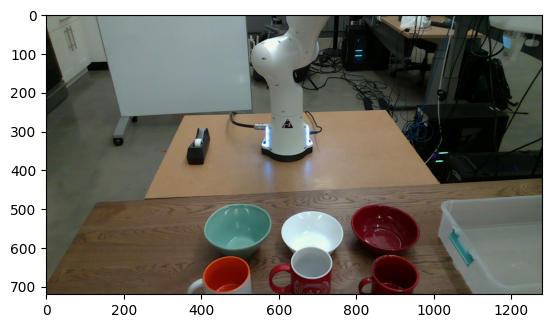

In [64]:
import matplotlib.pyplot as plt

plt.imshow(segmap)
plt.imshow(rgb)
cam_K

<Figure size 640x480 with 0 Axes>

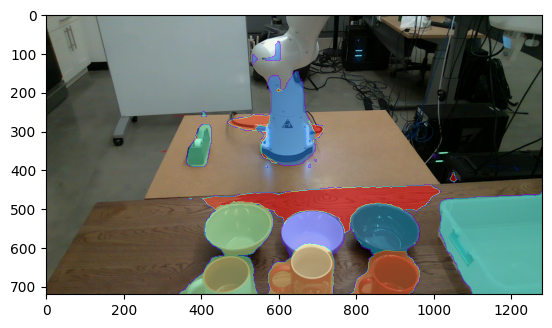

In [65]:
# Visualize results          
show_image(rgb, segmap)

In [68]:
visualize_grasps(pc_full, pred_grasps_cam, scores, plot_opencv_cam=True, pc_colors=pc_colors)


Visualizing...takes time


In [26]:
scores

{-1: array([0.20896627, 0.46020553, 0.3200999 , 0.3031402 , 0.1948674 ,
        0.290245  , 0.24260771, 0.25473285, 0.25792634, 0.18596429,
        0.18546318, 0.23066571, 0.19582361, 0.19140694, 0.4846375 ,
        0.34291855, 0.45076394, 0.4891804 , 0.28008303, 0.19436851,
        0.32264763, 0.4109733 , 0.3391857 , 0.202856  , 0.20513584,
        0.20134763, 0.18551873, 0.41362697, 0.39872852, 0.32082996,
        0.2756014 , 0.2804396 , 0.30791447, 0.4835043 , 0.21650815,
        0.38701546, 0.4114386 , 0.26607162, 0.26472613, 0.18385923,
        0.34496507, 0.36034104, 0.21622904, 0.23073195, 0.21207236,
        0.4657473 , 0.3955174 , 0.18226823, 0.18391545, 0.48528874,
        0.18827473, 0.32513702, 0.340691  , 0.1950294 , 0.5658754 ,
        0.35433802, 0.6107681 , 0.6492519 , 0.3413106 , 0.187747  ,
        0.29077035, 0.2362834 , 0.19505547, 0.20083858, 0.49359015,
        0.33197457, 0.4968672 , 0.2231319 , 0.49593902, 0.2780316 ,
        0.2791063 , 0.1865419 , 0.45413375, 

## Acronym mesh_contacts 파일 뜯어보기

In [29]:
bowl = np.load('/home/juju/contact_graspnet/acronym/mesh_contacts/Bowl_fa23aa60ec51c8e4c40fe5637f0a27e1_0.0006927004766994205.npz')

In [30]:
for i in bowl:
    print(i)

collisions
valid_locations
successful
grasp_transform
contact_points
contact_directions
contact_face_normals
contact_offsets


In [60]:
# successful : grasp 성공인지아닌지
np.where(bowl['successful'])
# grasp을 위한 eef_pose
bowl['grasp_transform']
# gripper 손가락의 direction (내생각)  shape : 2x3
bowl['contact_directions'] 
# gripper가 닿을 object의 face normal (확실치 않음)
bowl['contact_face_normals'][0]
# 모르겠네.. 코드 봐야할듯. 
bowl['contact_offsets']

print()